In [33]:
from matplotlib import pyplot as plt
import numpy as np
import re

# Select all files to load via regex
regex = ".*"

# Files to load. t = num_timesteps, l = lut_depth, s = samples, w = reward weights
files = [
    f"lut_t={t}_l=2_w={'1'*t}_noise={noise}_s={s}"  for t in [3] for noise in ["0.0", "0.5", "1.0", "1.5", "2.0", "3.5", "4.0", "inf"] for s in range(10)
]

fidelities_each = []
loaded_files = []
for file in files:
    if not re.match(regex, file):
        continue

    data = np.load(f"{file}.npz")
    fidelities_each.append(data)
    loaded_files.append(file)

baseline_fidelities = np.load("baseline_fidelities.npz")["fidelities"]

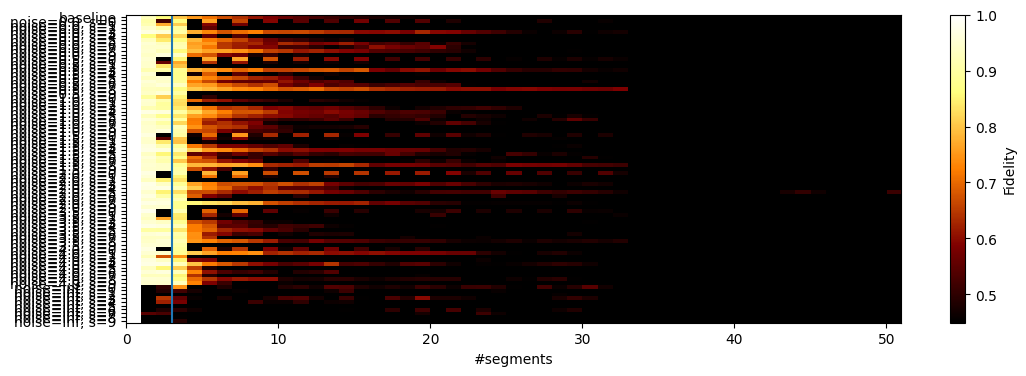

In [34]:
# Read fidelities into matrix and plot 2D graph
label_each = []
first_value = None
for value in fidelities_each[0].values():
    first_value = value
    break
fidelities_mat = np.zeros((len(fidelities_each), len(first_value)))

fig, ax = plt.subplots(1,1, figsize=(12.5,4))
for i, (filename, fidelities) in enumerate(zip(loaded_files, fidelities_each)):
    color = (
        "lightgrey" if "grape" in filename else
        "tab:blue"  if "lut" in filename else
        "tab:orange" # rnn
    )

    keyword = (
        "fidelities_grape" if "grape" in filename else
        "fidelities_lut"  if "lut" in filename else
        "fidelities_rnn" # rnn
    )

    F = fidelities[keyword]

    # extract variables from filename
    protocol = re.search(r'^(grape|lut|rnn)', filename).group(1)
    t = int(re.search(r't=(\d+)', filename).group(1))
    w = re.search(r'w=(\d+)', filename).group(1)
    s = int(re.search(r's=(\d+)', filename).group(1))
    noise = float(re.search(r'noise=([\d.]+|inf)', filename).group(1))

    if protocol == "lut":
        l = int(re.search(r'l=(\d+)', filename).group(1))
        label = f"noise={noise}, s={s}"
    else:
        pass#label = f"{protocol}, t={t}, w={w}, noise={noise}"

    fidelities_mat[i,:] = F
    label_each.append(label)

# Add baseline fidelities as first row
fidelities_mat = np.vstack([baseline_fidelities, fidelities_mat])
label_each = ["baseline"] + label_each

im = ax.imshow(
    fidelities_mat,
    aspect="auto",
    cmap="afmhot",
    vmin=baseline_fidelities[-1], # for better contrast in colormap
    vmax=1.0,
    extent=[0, fidelities_mat.shape[1], fidelities_mat.shape[0], 0],
    interpolation="none",
)
fig.colorbar(im, ax=ax, label="Fidelity")

#ax.set_xlim(0, 10)
ax.set_xlabel("#segments")
ax.set_yticks(np.arange(len(label_each))+0.5)
ax.set_yticklabels(label_each)
ax.axvline(x=3)
fig.savefig("fidelity_comparison", bbox_inches="tight")

[0.36421374 0.30757975 0.25010307 0.45379239 0.31963932 0.36433352
 0.41613714 0.40320535 0.43295646 0.34136554 0.3809661  0.34690904
 0.25921442 0.46123634 0.3378173  0.38345035 0.38750553 0.4074384
 0.48237786 0.26322598 0.32519439 0.33790003 0.23449057 0.40158816
 0.41143345 0.46145743 0.39727407 0.37241811 0.37836044 0.37285918
 0.39350881 0.34031545 0.31200232 0.37802882 0.41982069 0.4602904
 0.36164197 0.3737685  0.4634111  0.3594128  0.39907076 0.31898729
 0.31638339 0.43076511 0.38404795 0.52868008 0.36774036 0.26886286
 0.44318659 0.28478671 0.36893633 0.35374967 0.30957584 0.36125125
 0.36899668 0.42095393 0.3712128  0.34926645 0.42078131 0.27009676
 0.35143344 0.4419027  0.30575791 0.34958191 0.41621465 0.3101701
 0.36910753 0.32089398 0.38940673 0.37662499 0.3616374  0.31851733
 0.28611027 0.35279174 0.30813277 0.28573608 0.3212617  0.30675679
 0.24947476 0.2782665 ]


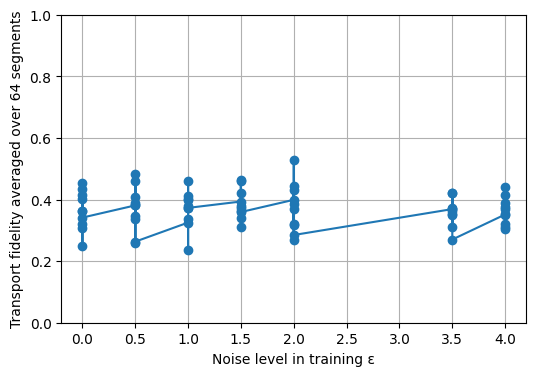

In [35]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
mean_fid = fidelities_mat[1:,:64].mean(axis=1)
print(mean_fid)
noise = [float(re.search(r'noise=([\d.]+|inf)', filename).group(1)) for filename in loaded_files]
ax.plot(noise, mean_fid, marker='o')
ax.set_xlabel("Noise level in training ε")
ax.set_ylabel("Transport fidelity averaged over 64 segments")
ax.set_ylim(0,1)
ax.grid()

fig.savefig("mean_fidelity_vs_noise.png", bbox_inches="tight")